## **CAMPAIGN SEGMENTATION**

Segmentasi K-Means Clustering untuk campaign ads bertujuan untuk membagi audiens menjadi beberapa kelompok berdasarkan karakteristik dan perilaku mereka, sehingga dapat meningkatkan efektivitas dan efisiensi kampanye iklan. Tujuan :
1. Mengidentifikasi audiens yang relevan
2. Meningkatkan efektivitas iklan
3. Mengoptimalkan biaya iklan
4. Mengukur efektivitas kampanye

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col

In [ ]:
!pip install requests
import requests


In [ ]:
#Membuat spark dan memanggil data

spark = SparkSession.builder.appName('Segmentasi_session').getOrCreate()

# Memanggil Data
url_csv = "https://raw.githubusercontent.com/bunga-netizen62/Big-Data/main/dataset.csv" # link ke github data

# Download data
response = requests.get(url_csv)
with open("dataset.csv", "wb") as f:
    f.write(response.content)


df = spark.read.csv('/content/dataset.csv', header=True,sep=';', inferSchema=True)
df.show()

+------------+--------+--------+--------------+----+-------+------+-------+
|BRAND (AUTO)|    DATE| NAMA CS|      Greating|Lead|Closing| Omset|  SPEND|
+------------+--------+--------+--------------+----+-------+------+-------+
|          Cg|01/10/24| NINGRUM|     sisgolden|   9|      3|597000| 833058|
|          Cg|01/10/24|   NURUL|    Hei minsei|   6|      2|583000| 555372|
|          Cg|01/10/24|   NURUL|     sisgolden|   5|      3|625500| 462810|
|          Cg|01/10/24|   RETNO|    Hei minsei|   3|      3|597000| 277686|
|          Cg|01/10/24|   RETNO|   Helo siscol|   0|      1|199000|      0|
|          Cg|01/10/24|   RETNO|     sisgolden|   8|      1|199000| 740496|
|          Cg|01/10/24|   RETNO|       Hai kak|   7|      0|     0| 647934|
|          Cg|01/10/24|    HENI|     sisgolden|   0|      1|199000|      0|
|          Cg|01/10/24|    RULI|    Hei minsei|   0|      0|     0|      0|
|          Cg|01/10/24|    RULI|         Kakak|   2|      1|239000| 185124|
|          C

In [ ]:
#Mengatasi missing value

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, when, isnull


df = df.withColumn("Lead", when(isnull(col("Lead")), 0).otherwise(col("Lead")))
df = df.withColumn("Closing", when(isnull(col("Closing")), 0).otherwise(col("Closing")))

In [ ]:
# Menggabungkan variabel Closing & Lead menjadi 1 fitur
assembler   = VectorAssembler(inputCols=['Closing','Lead'], outputCol='features')
final_df    = assembler.transform(df)

#Normalisasi fitur untuk memastikan fitur dalam skala angka yang sama
scaler      = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(final_df)
final_df    = scalerModel.transform(final_df)

In [ ]:
final_df.show()

+------------+--------+--------+--------------+----+-------+------+-------+----------+--------------------+
|BRAND (AUTO)|    DATE| NAMA CS|      Greating|Lead|Closing| Omset|  SPEND|  features|      scaledFeatures|
+------------+--------+--------+--------------+----+-------+------+-------+----------+--------------------+
|          Cg|01/10/24| NINGRUM|     sisgolden|   9|      3|597000| 833058| [3.0,9.0]|[1.39896274534135...|
|          Cg|01/10/24|   NURUL|    Hei minsei|   6|      2|583000| 555372| [2.0,6.0]|[0.93264183022757...|
|          Cg|01/10/24|   NURUL|     sisgolden|   5|      3|625500| 462810| [3.0,5.0]|[1.39896274534135...|
|          Cg|01/10/24|   RETNO|    Hei minsei|   3|      3|597000| 277686| [3.0,3.0]|[1.39896274534135...|
|          Cg|01/10/24|   RETNO|   Helo siscol|   0|      1|199000|      0| [1.0,0.0]|[0.46632091511378...|
|          Cg|01/10/24|   RETNO|     sisgolden|   8|      1|199000| 740496| [1.0,8.0]|[0.46632091511378...|
|          Cg|01/10/24|   RE

In [ ]:
final_df.printSchema()

root
 |-- BRAND (AUTO): string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- NAMA CS: string (nullable = true)
 |-- Greating: string (nullable = true)
 |-- Lead: integer (nullable = true)
 |-- Closing: integer (nullable = true)
 |-- Omset: string (nullable = true)
 |-- SPEND: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)



In [ ]:
#Sesi clustering
from pyspark.ml.clustering import KMeans

In [ ]:
# Mengelompokkan campaign menjadi 5 cluster
kmeans       = KMeans(featuresCol="scaledFeatures", k=5)
model_kmeans = kmeans.fit(final_df)

# Mendapatkan hasil clustering
predictions_kmeans = model_kmeans.transform(final_df)
predictions_kmeans.show()

+------------+--------+--------+--------------+----+-------+------+-------+----------+--------------------+----------+
|BRAND (AUTO)|    DATE| NAMA CS|      Greating|Lead|Closing| Omset|  SPEND|  features|      scaledFeatures|prediction|
+------------+--------+--------+--------------+----+-------+------+-------+----------+--------------------+----------+
|          Cg|01/10/24| NINGRUM|     sisgolden|   9|      3|597000| 833058| [3.0,9.0]|[1.39896274534135...|         4|
|          Cg|01/10/24|   NURUL|    Hei minsei|   6|      2|583000| 555372| [2.0,6.0]|[0.93264183022757...|         4|
|          Cg|01/10/24|   NURUL|     sisgolden|   5|      3|625500| 462810| [3.0,5.0]|[1.39896274534135...|         4|
|          Cg|01/10/24|   RETNO|    Hei minsei|   3|      3|597000| 277686| [3.0,3.0]|[1.39896274534135...|         4|
|          Cg|01/10/24|   RETNO|   Helo siscol|   0|      1|199000|      0| [1.0,0.0]|[0.46632091511378...|         2|
|          Cg|01/10/24|   RETNO|     sisgolden| 

In [ ]:
#Tahap visualisasi

!pip install matplotlib
import matplotlib.pyplot as plt

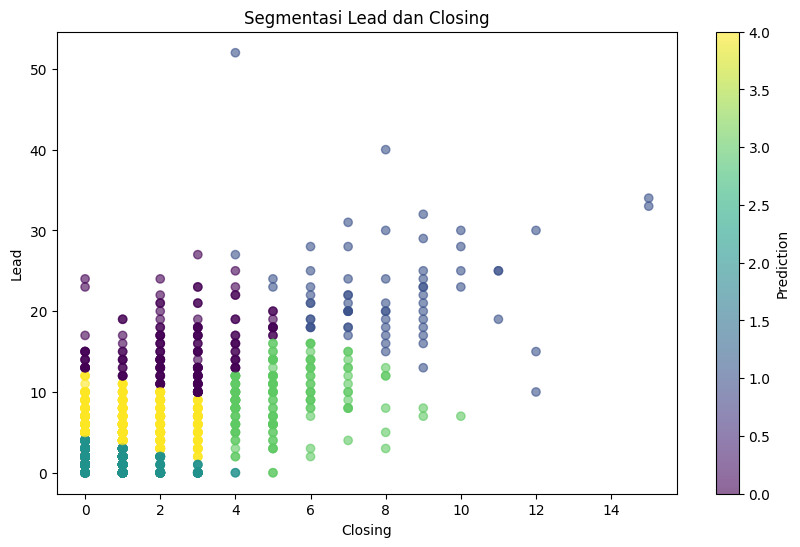

In [ ]:
# Convert data Pyspark to Python lists
closing_data    = predictions_kmeans.select('Closing').rdd.flatMap(lambda x: x).collect()
lead_data       = predictions_kmeans.select('Lead').rdd.flatMap(lambda x: x).collect()
prediction_data = predictions_kmeans.select('prediction').rdd.flatMap(lambda x: x).collect()


plt.figure(figsize=(10, 6))
plt.scatter(closing_data, lead_data, c=prediction_data, cmap='viridis', alpha=0.6)
plt.xlabel('Closing')
plt.ylabel('Lead')
plt.title('Segmentasi Lead dan Closing')
plt.colorbar(label='Prediction')
plt.show()

In [ ]:
# Menyimpan hasil segmentasi ke file Excel
data_predictions    = predictions_kmeans.toPandas()
data_predictions.to_excel("Sefmentasi Cluster Campaign.xlsx", index=False, engine='openpyxl')

In [ ]:
spark.stop()

# **LEAD PREDICTION**

Lead prediction untuk memprediksi kemungkinan seorang pelanggan potensial (lead) untuk melakukan pembelian atau mengambil tindakan lain yang diinginkan.Tujuan:
1. Membantu untuk menentukan target berapa lead berkualitas yang kita perlukan dengan anggaran dan target closing yang harus dicapai
2. Mengoptimalkan spend Ads
3. Meningkatkan efektivitas closing


In [ ]:
#Membuat spark session dan meanggil data
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Predicted_session').getOrCreate()


data = spark.read.csv('/content/dataset.csv', header=True,sep=';', inferSchema=True)
data.show(3)

+------------+--------+-------+----------+----+-------+------+------+
|BRAND (AUTO)|    DATE|NAMA CS|  Greating|Lead|Closing| Omset| SPEND|
+------------+--------+-------+----------+----+-------+------+------+
|          Cg|01/10/24|NINGRUM| sisgolden|   9|      3|597000|833058|
|          Cg|01/10/24|  NURUL|Hei minsei|   6|      2|583000|555372|
|          Cg|01/10/24|  NURUL| sisgolden|   5|      3|625500|462810|
+------------+--------+-------+----------+----+-------+------+------+
only showing top 3 rows



In [ ]:
#Menghapus data Nan dan filter lead 0
data_clean = data.na.drop(subset=["Closing", "SPEND"])
data_clean = data.filter(data["Lead"] > 0)

# Menggabungkan variabel Closing & Spend menjadi 1 fitur
assembler = VectorAssembler(inputCols = ['Closing', 'SPEND'], outputCol = 'features')
data_final = assembler.transform(data_clean)
data_final.printSchema()

root
 |-- BRAND (AUTO): string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- NAMA CS: string (nullable = true)
 |-- Greating: string (nullable = true)
 |-- Lead: integer (nullable = true)
 |-- Closing: integer (nullable = true)
 |-- Omset: string (nullable = true)
 |-- SPEND: integer (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
data_final.show()

+------------+--------+--------+--------------+----+-------+-------+-------+---------------+
|BRAND (AUTO)|    DATE| NAMA CS|      Greating|Lead|Closing|  Omset|  SPEND|       features|
+------------+--------+--------+--------------+----+-------+-------+-------+---------------+
|          Cg|01/10/24| NINGRUM|     sisgolden|   9|      3| 597000| 833058| [3.0,833058.0]|
|          Cg|01/10/24|   NURUL|    Hei minsei|   6|      2| 583000| 555372| [2.0,555372.0]|
|          Cg|01/10/24|   NURUL|     sisgolden|   5|      3| 625500| 462810| [3.0,462810.0]|
|          Cg|01/10/24|   RETNO|    Hei minsei|   3|      3| 597000| 277686| [3.0,277686.0]|
|          Cg|01/10/24|   RETNO|     sisgolden|   8|      1| 199000| 740496| [1.0,740496.0]|
|          Cg|01/10/24|   RETNO|       Hai kak|   7|      0|      0| 647934| [0.0,647934.0]|
|          Cg|01/10/24|    RULI|         Kakak|   2|      1| 239000| 185124| [1.0,185124.0]|
|          Cg|01/10/24|    LINA|    Hei minsei|   9|      4| 991000| 8

In [ ]:
# Data selection, Lead adalah target yang akan diprediksi

data_final = data_final.select(['features', 'Lead'])
data_final.show(20)

+---------------+----+
|       features|Lead|
+---------------+----+
| [3.0,833058.0]|   9|
| [2.0,555372.0]|   6|
| [3.0,462810.0]|   5|
| [3.0,277686.0]|   3|
| [1.0,740496.0]|   8|
| [0.0,647934.0]|   7|
| [1.0,185124.0]|   2|
| [4.0,833058.0]|   9|
| [0.0,555372.0]|   6|
| [2.0,462810.0]|   5|
|  [0.0,92562.0]|   1|
| [1.0,277686.0]|   3|
|[3.0,1110744.0]|  12|
| [0.0,370248.0]|   4|
| [0.0,147741.0]|   1|
| [2.0,886446.0]|   6|
| [0.0,147741.0]|   1|
| [1.0,147741.0]|   1|
| [1.0,147741.0]|   1|
|[9.0,1034187.0]|   7|
+---------------+----+
only showing top 20 rows



In [ ]:
data_final.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Lead: integer (nullable = true)



In [ ]:
#Membagi dataset menjadi data train dan data testing

train, test = data_final.randomSplit([0.9, 0.1])
train.show(10)

+---------+----+
| features|Lead|
+---------+----+
|(2,[],[])|   1|
|(2,[],[])|   1|
|(2,[],[])|   1|
|(2,[],[])|   2|
|(2,[],[])|   2|
|(2,[],[])|   2|
|(2,[],[])|   3|
|(2,[],[])|   3|
|(2,[],[])|   3|
|(2,[],[])|   3|
+---------+----+
only showing top 10 rows



In [ ]:
# Membuat model prediksi menggunakan Linear Regresi
from pyspark.ml.regression import LinearRegression

lr       = LinearRegression(labelCol = 'Lead')
lr_model = lr.fit(train)

In [ ]:
predictions_lr = lr_model.transform(test)
predictions_lr.show(50)

+---------------+----+------------------+
|       features|Lead|        prediction|
+---------------+----+------------------+
|  [0.0,52754.0]|   1|1.6281246151485962|
|  [0.0,54889.0]|   1|1.6505567161042927|
|  [0.0,55590.0]|   2|1.6579220101417367|
|  [0.0,69327.0]|   1|1.8022544554946178|
|  [0.0,74227.0]|   1|1.8537379658847408|
|  [0.0,75974.0]|   1|1.8720934133646479|
|  [0.0,78693.0]|   1|1.9006615082117384|
|  [0.0,78693.0]|   1|1.9006615082117384|
|  [0.0,83528.0]|   1|1.9514620740762778|
|  [0.0,87754.0]|   1|1.9958639750780451|
|  [0.0,88788.0]|   1|2.0067280464542465|
|  [0.0,92562.0]|   1| 2.046380856293496|
| [0.0,100483.0]|   1| 2.129605526864958|
| [0.0,103144.0]|   2|2.1575642250584517|
| [0.0,103545.0]|  13|2.1617774674393573|
| [0.0,104571.0]|   1|2.1725574841047175|
| [0.0,106745.0]|   5| 2.195399351775764|
| [0.0,130146.0]|   2|2.4412698878245935|
| [0.0,139346.0]|   2| 2.537932805291763|
| [0.0,145530.0]|   2| 2.602907096771869|
| [0.0,165759.0]|   2|2.8154499399

In [ ]:
# Membuat model prediksi menggunakan Random Forest
from pyspark.ml.regression import RandomForestRegressor

rf        = RandomForestRegressor(featuresCol="features", labelCol="Lead")
rf_model  = rf.fit(train)

In [ ]:
predictions_rf = rf_model.transform(test)
predictions_rf.show(50)

+---------------+----+------------------+
|       features|Lead|        prediction|
+---------------+----+------------------+
|  [0.0,52754.0]|   1| 2.009982334537116|
|  [0.0,54889.0]|   1| 2.009982334537116|
|  [0.0,55590.0]|   2| 2.009982334537116|
|  [0.0,69327.0]|   1| 2.009982334537116|
|  [0.0,74227.0]|   1| 2.009982334537116|
|  [0.0,75974.0]|   1| 2.009982334537116|
|  [0.0,78693.0]|   1| 2.009982334537116|
|  [0.0,78693.0]|   1| 2.009982334537116|
|  [0.0,83528.0]|   1| 2.009982334537116|
|  [0.0,87754.0]|   1| 2.009982334537116|
|  [0.0,88788.0]|   1| 2.009982334537116|
|  [0.0,92562.0]|   1| 2.009982334537116|
| [0.0,100483.0]|   1| 2.009982334537116|
| [0.0,103144.0]|   2| 2.009982334537116|
| [0.0,103545.0]|  13| 2.009982334537116|
| [0.0,104571.0]|   1| 2.009982334537116|
| [0.0,106745.0]|   5| 2.009982334537116|
| [0.0,130146.0]|   2|2.2660311822134034|
| [0.0,139346.0]|   2|2.2660311822134034|
| [0.0,145530.0]|   2|2.2660311822134034|
| [0.0,165759.0]|   2|2.7891865012

In [ ]:
# Membuat model prediksi menggunakan Decision Tree
from pyspark.ml.regression import DecisionTreeRegressor

dt       = DecisionTreeRegressor(labelCol = 'Lead')
dt_model = dt.fit(train)

In [ ]:
predictions_dt = dt_model.transform(test)
predictions_dt.show(50)

+---------------+----+------------------+
|       features|Lead|        prediction|
+---------------+----+------------------+
|  [0.0,52754.0]|   1|1.3105263157894738|
|  [0.0,54889.0]|   1|1.3105263157894738|
|  [0.0,55590.0]|   2|1.3105263157894738|
|  [0.0,69327.0]|   1|1.3105263157894738|
|  [0.0,74227.0]|   1|1.3105263157894738|
|  [0.0,75974.0]|   1|1.3105263157894738|
|  [0.0,78693.0]|   1|1.3105263157894738|
|  [0.0,78693.0]|   1|1.3105263157894738|
|  [0.0,83528.0]|   1|1.3105263157894738|
|  [0.0,87754.0]|   1|1.3105263157894738|
|  [0.0,88788.0]|   1|1.3105263157894738|
|  [0.0,92562.0]|   1|1.3105263157894738|
| [0.0,100483.0]|   1|2.1491228070175437|
| [0.0,103144.0]|   2|2.1491228070175437|
| [0.0,103545.0]|  13|2.1491228070175437|
| [0.0,104571.0]|   1|2.1491228070175437|
| [0.0,106745.0]|   5|2.1491228070175437|
| [0.0,130146.0]|   2|2.1491228070175437|
| [0.0,139346.0]|   2|2.1491228070175437|
| [0.0,145530.0]|   2|2.1491228070175437|
| [0.0,165759.0]|   2| 3.107843137

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="Lead", predictionCol="prediction", metricName="rmse")
rmse_lr = evaluator.evaluate(predictions_lr)
rmse_rf = evaluator.evaluate(predictions_rf)
rmse_dt = evaluator.evaluate(predictions_dt)

print(f"Root Mean Squared Error (RMSE) for Linear Regression: {rmse_lr}")
print(f"Root Mean Squared Error (RMSE) for Random Forest: {rmse_rf}")
print(f"Root Mean Squared Error (RMSE) for Decision Tree: {rmse_dt}")

Root Mean Squared Error (RMSE) for Linear Regression: 2.9010671702980426
Root Mean Squared Error (RMSE) for Random Forest: 2.861012131774818
Root Mean Squared Error (RMSE) for Decision Tree: 2.8928586894087474


# **Prediksi data baru**
Peringkat model
1. Random Forest (RMSE: 2.861012131774818)
2. Decision Tree (RMSE: 2.8928586894087474)
3. Linear Regression (RMSE: 2.9010671702980426)
Dalam kasus ini, Random Forest dapat dianggap sebagai model yang paling baik karena memiliki nilai RMSE yang paling rendah dan akan digunakan untuk memprediksi data baru.


In [ ]:
# Memanggil Data Predict
url_csv = "https://raw.githubusercontent.com/bunga-netizen62/Big-Data/main/predict-data-baru.csv" # link ke github data

# Download data
response = requests.get(url_csv)
with open("predict-data-baru.csv", "wb") as f:
    f.write(response.content)


predict = spark.read.csv('/content/predict-data-baru.csv', header=True,sep=';', inferSchema=True)
predict.show()

+----------+-------+----+-------+
|   Cluster|Closing|Lead|  SPEND|
+----------+-------+----+-------+
|Light Blue|     14|NULL|1800000|
|    Purple|      2|NULL| 120000|
|     Green|      8|NULL| 800000|
|    Yellow|      2|NULL| 600000|
| Dark Blue|      1|NULL| 250000|
+----------+-------+----+-------+



In [ ]:
assembler = VectorAssembler(inputCols = ['Closing', 'SPEND'], outputCol = 'features')
predict_data = assembler.transform(predict)
predict_data.printSchema()

root
 |-- Cluster: string (nullable = true)
 |-- Closing: integer (nullable = true)
 |-- Lead: string (nullable = true)
 |-- SPEND: integer (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
predict_rf = rf_model.transform(predict_data)
predict_rf.show()

+----------+-------+----+-------+----------------+------------------+
|   Cluster|Closing|Lead|  SPEND|        features|        prediction|
+----------+-------+----+-------+----------------+------------------+
|Light Blue|     14|NULL|1800000|[14.0,1800000.0]| 28.83517167015619|
|    Purple|      2|NULL| 120000|  [2.0,120000.0]| 4.306228618478361|
|     Green|      8|NULL| 800000|  [8.0,800000.0]|13.122293250683523|
|    Yellow|      2|NULL| 600000|  [2.0,600000.0]| 7.606668918403559|
| Dark Blue|      1|NULL| 250000|  [1.0,250000.0]|  4.15597310182166|
+----------+-------+----+-------+----------------+------------------+



In [ ]:
hasil_rf = predict_rf.toPandas()
hasil_rf

,Cluster,Closing,Lead,SPEND,features,prediction
0,Light Blue,14,None,1800000,"[14.0, 1800000.0]",28.835172
1,Purple,2,None,120000,"[2.0, 120000.0]",4.306229
2,Green,8,None,800000,"[8.0, 800000.0]",13.122293
3,Yellow,2,None,600000,"[2.0, 600000.0]",7.606669
4,Dark Blue,1,None,250000,"[1.0, 250000.0]",4.155973


In [ ]:
hasil_rf.to_excel("hasil_rf.xlsx", index=False, engine='openpyxl')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **EVALUASI CAUSAL IMPACT**

Causal Impact Analysis (CIA) pada campaign dilakukan setelah menerapkan hasil prediksi pada campaign di bulan Desember pada minggu pertama. Tujuan CIA ini digunakan untuk mengukur besar efek dari penerapan hasil prediksi pada cluster - cluster campaign.

In [ ]:
pip install pycausalimpact

In [ ]:
import numpy as np
import pandas as pd
from causalimpact import CausalImpact

In [ ]:
#url = 'https://raw.githubusercontent.com/bunga-netizen62/Big-Data/main/data-causal.csv'

#data = pd.read_csv(url ,header=0, sep=';', decimal=',')
#data

,DATE,OMSET,SPEND,ROAS
0,01/09/24,398000,391389,1.0
1,02/09/24,57114000,7531888,7.6
2,03/09/24,8990219,9862092,0.9
3,04/09/24,6693000,9083107,0.7
4,05/09/24,9641000,9370561,1.0
...,...,...,...,...
95,05/12/24,14769000,15489948,1.0
96,06/12/24,20130000,15448339,1.3
97,07/12/24,19462000,19185971,1.0
98,08/12/24,14337000,12864617,1.1


In [ ]:
data = pd.read_excel('/content/data_causal2.xlsx')
data

,DATE,OMSET,SPEND,ROAS
0,2024-09-01,398000,391389,1.016891
1,2024-09-02,57114000,7531888,7.582959
2,2024-09-03,8990219,9862092,0.911594
3,2024-09-04,6693000,9083107,0.736862
4,2024-09-05,9641000,9370561,1.028860
...,...,...,...,...
95,2024-12-05,14769000,15489948,0.953457
96,2024-12-06,20130000,15448339,1.303053
97,2024-12-07,19462000,19185971,1.014387
98,2024-12-08,14337000,12864617,1.114452


In [ ]:
data['DATE'] = pd.to_datetime(data['DATE'])
data_roas    = data[['DATE', 'ROAS']]
data_roas

,DATE,ROAS
0,2024-09-01,1.016891
1,2024-09-02,7.582959
2,2024-09-03,0.911594
3,2024-09-04,0.736862
4,2024-09-05,1.028860
...,...,...
95,2024-12-05,0.953457
96,2024-12-06,1.303053
97,2024-12-07,1.014387
98,2024-12-08,1.114452


In [ ]:
data_roas = data_roas.set_index('DATE')

# Corrected date format and range
pre_period  = ['2024-09-01', '2024-11-30']  # Periode sebelum intervensi, date corrected to '2024-11-30'
post_period = ['2024-12-01', '2024-12-09']  # Periode setelah intervensi, adjusted to be within data range

ci = CausalImpact(data_roas, pre_period, post_period)

/usr/local/lib/python3.10/dist-packages/causalimpact/main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
/usr/local/lib/python3.10/dist-packages/causalimpact/main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, boun

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1.15               10.39
Prediction (s.d.)         1.04 (0.3)         9.39 (2.69)
95% CI                    [0.42, 1.59]       [3.76, 14.3]

Absolute effect (s.d.)    0.11 (0.3)         1.0 (2.69)
95% CI                    [-0.44, 0.74]      [-3.92, 6.62]

Relative effect (s.d.)    10.62% (28.65%)    10.62% (28.65%)
95% CI                    [-41.73%, 70.56%]  [-41.73%, 70.56%]

Posterior tail-area probability p: 0.36
Posterior prob. of a causal effect: 63.54%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1.15. In the absence of an
intervention, we would have expected an average response of 1.04.
The 95% interval of this counterfactual prediction is [0.42, 1.59].
Subtracting this prediction from the observed response yields
an 

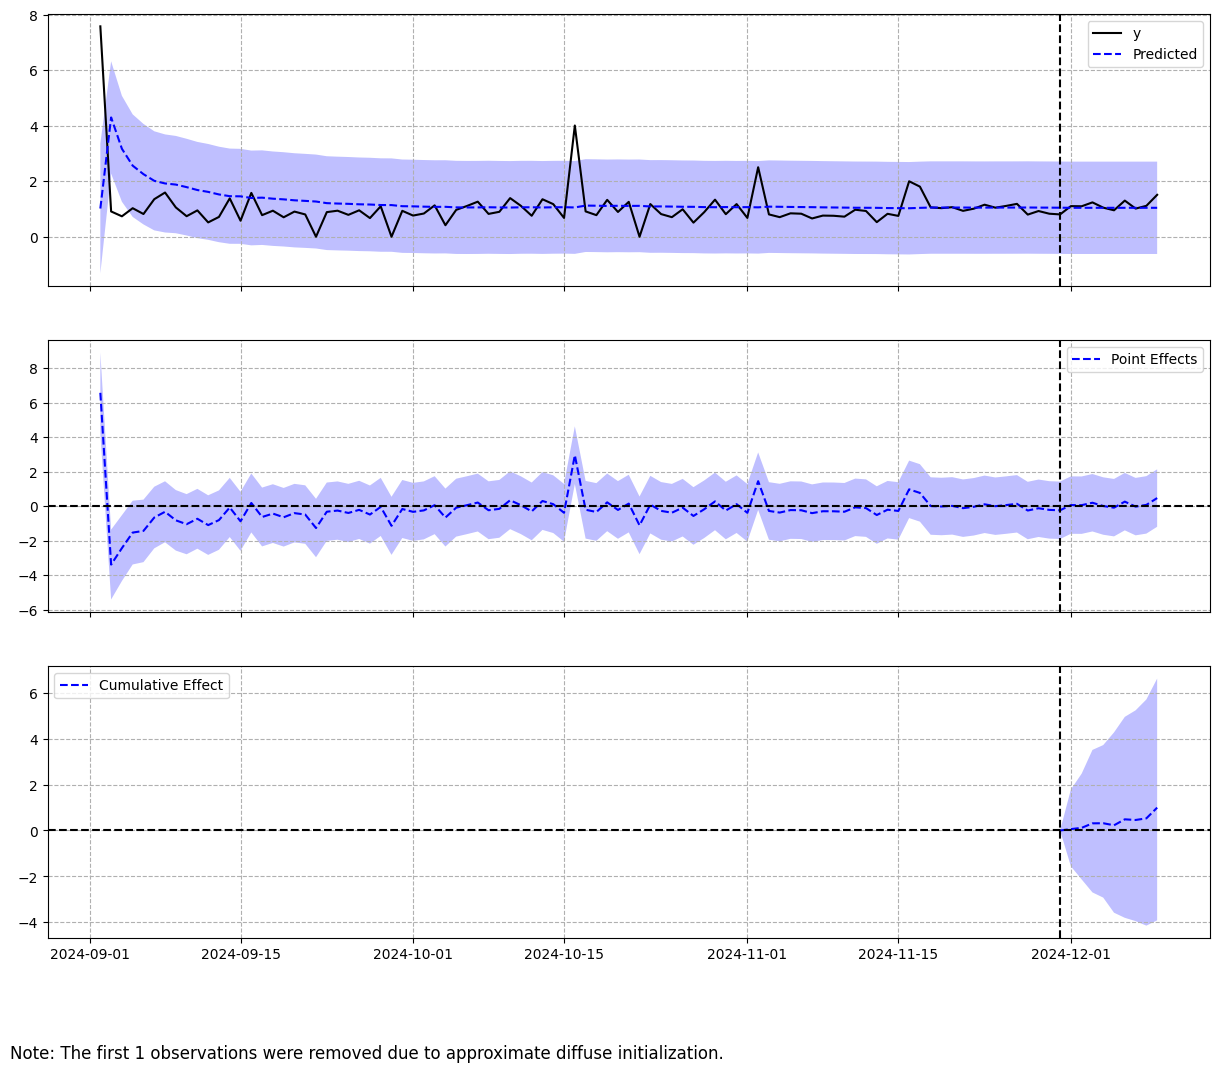

In [ ]:
# Menampilkan ringkasan hasil analisis
print(ci.summary())
print(ci.summary(output='report'))

# Menampilkan plot hasil analisis
ci.plot()